# Weak Labeling for Semi-Supervised Sentiment Analysis

**Table of Contents**
1. [Setup](#setup)  
2. [Load datasets](#load-datasets)  
3. [Sentence embeddings](#sentence-embeddings)  
4. [Evaluation function](#evaluation-function)  
5. [Comparison between embedding models](#compare-embeddings)  
6. [Approach 1: Logistic Regression](#approach-1)  
7. [Approach 2: K-Nearest Neighbors](#approach-2)  
8. [Approach 3: Random Forest](#approach-3)  
9. [Approach 4: Support Vector Machine](#approach-4)  
10. [Comparison of all approaches](#compare-approaches)  
11. [Summary](#summary)  
12. [Saving the best model](#saving-model)  

### Setup

In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import rootutils
import os

root = rootutils.setup_root(search_from=".", indicator=".git")

DATA_DIR = root / "data"

### Load datasets

In [2]:
# Load splits
validation = pd.read_parquet(os.path.join(DATA_DIR, "validation.parquet"))
labeled    = pd.read_parquet(os.path.join(DATA_DIR, "labeled.parquet"))
unlabeled  = pd.read_parquet(os.path.join(DATA_DIR, "unlabeled.parquet"))

# Quick sanity check
print("Validation:", validation.label.value_counts().to_dict())
print("Labeled   :", labeled.label.value_counts().to_dict())
print("Unlabeled :", unlabeled.label.value_counts().to_dict())

Validation: {1: 400, 0: 400}
Labeled   : {0: 200, 1: 200}
Unlabeled : {1: 1400, 0: 1400}


### Sentence embeddings

In [3]:
models = {
    "all-MiniLM-L6-v2": SentenceTransformer("all-MiniLM-L6-v2"),      # fast, small
    "all-mpnet-base-v2": SentenceTransformer("all-mpnet-base-v2"),    # higher-quality
}

def embed_texts(model, texts, batch_size=64):
    """Compute embeddings in batches with progress bar."""
    return model.encode(texts, batch_size=batch_size, show_progress_bar=True)

# Precompute embeddings
embeddings = {}
for name, model in models.items():
    embeddings[name] = {
        "labeled":    embed_texts(model, labeled["content"].tolist()),
        "validation": embed_texts(model, validation["content"].tolist()),
        "unlabeled":  embed_texts(model, unlabeled["content"].tolist()),
    }

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

### Evaluation function

In [4]:
def evaluate(y_true, y_pred, verbose=True, plot_confusion_matrix=False):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
    report = classification_report(y_true, y_pred)

    if verbose:
        print("===== Evaluation Metrics =====")
        print(f"Accuracy : {acc:.7f}")
        print(f"Precision: {prec:.7f}")
        print(f"Recall   : {rec:.7f}")
        print(f"F1 Score : {f1:.7f}")
        print("\n===== Classification Report =====")
        print(report)

    if plot_confusion_matrix:
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    return {
        "classification_report": classification_report(y_true, y_pred, output_dict=True),
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

### Comparison between embedding models

In [5]:
results_embed = {}
for name in models:
    X_tr = embeddings[name]["labeled"]
    y_tr = labeled["label"].values
    X_val = embeddings[name]["validation"]
    y_val = validation["label"].values

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_tr, y_tr)
    preds = clf.predict(X_val)
    results_embed[name] = evaluate(y_val, preds, verbose=False)

pd.DataFrame(results_embed).T

,classification_report,accuracy,precision,recall,f1
all-MiniLM-L6-v2,"{'0': {'precision': 0.7735849056603774, 'recal...",0.75375,0.736597,0.79,0.762364
all-mpnet-base-v2,"{'0': {'precision': 0.8350515463917526, 'recal...",0.825,0.815534,0.84,0.827586


In [6]:
BEST_EMB = max(results_embed, key=lambda k: results_embed[k]["f1"])
print("Using embedding:", BEST_EMB)

Using embedding: all-mpnet-base-v2


### Approach 1: Logistic Regression

===== Evaluation Metrics =====
Accuracy : 0.8353571
Precision: 0.8365591
Recall   : 0.8335714
F1 Score : 0.8350626

===== Classification Report =====
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1400
           1       0.84      0.83      0.84      1400

    accuracy                           0.84      2800
   macro avg       0.84      0.84      0.84      2800
weighted avg       0.84      0.84      0.84      2800



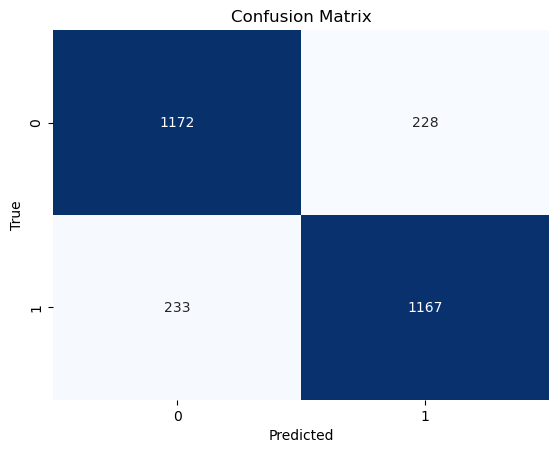

In [7]:
# Train on labeled, predict on unlabeled
X_lab = embeddings[BEST_EMB]["labeled"]
y_lab = labeled["label"].values
X_unl = embeddings[BEST_EMB]["unlabeled"]
y_unl = unlabeled["label"].values  # ground truth for evaluation

lr = LogisticRegression(max_iter=100_000)
lr.fit(X_lab, y_lab)
weak_labels_lr = lr.predict(X_unl)

metrics_lr = evaluate(y_unl, weak_labels_lr, plot_confusion_matrix=True)

### Approach 2: K-Nearest Neighbors

===== Evaluation Metrics =====
Accuracy : 0.7042857
Precision: 0.7237872
Recall   : 0.6607143
F1 Score : 0.6908140

===== Classification Report =====
              precision    recall  f1-score   support

           0       0.69      0.75      0.72      1400
           1       0.72      0.66      0.69      1400

    accuracy                           0.70      2800
   macro avg       0.71      0.70      0.70      2800
weighted avg       0.71      0.70      0.70      2800



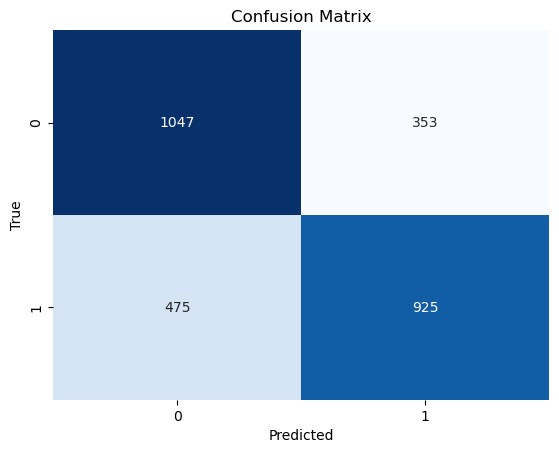

In [8]:
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn.fit(X_lab, y_lab)
weak_labels_knn = knn.predict(X_unl)

metrics_knn = evaluate(y_unl, weak_labels_knn, plot_confusion_matrix=True)

### Approach 3: Random Forest

===== Evaluation Metrics =====
Accuracy : 0.7867857
Precision: 0.7945708
Recall   : 0.7735714
F1 Score : 0.7839305

===== Classification Report =====
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1400
           1       0.79      0.77      0.78      1400

    accuracy                           0.79      2800
   macro avg       0.79      0.79      0.79      2800
weighted avg       0.79      0.79      0.79      2800



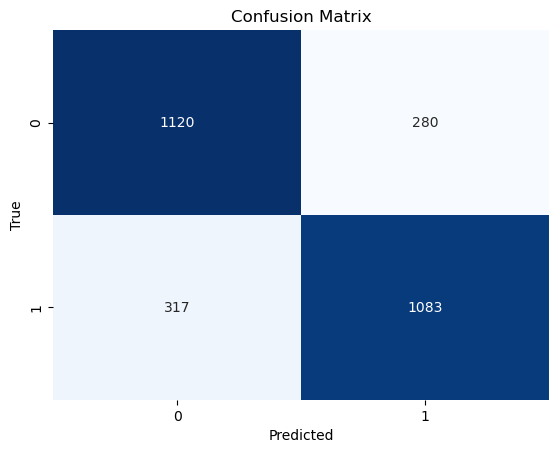

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_lab, y_lab)
weak_labels_rf = rf.predict(X_unl)

metrics_rf = evaluate(y_unl, weak_labels_rf, plot_confusion_matrix=True)

### Approach 4: Support Vector Machine

===== Evaluation Metrics =====
Accuracy : 0.8321429
Precision: 0.8242678
Recall   : 0.8442857
F1 Score : 0.8341567

===== Classification Report =====
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1400
           1       0.82      0.84      0.83      1400

    accuracy                           0.83      2800
   macro avg       0.83      0.83      0.83      2800
weighted avg       0.83      0.83      0.83      2800



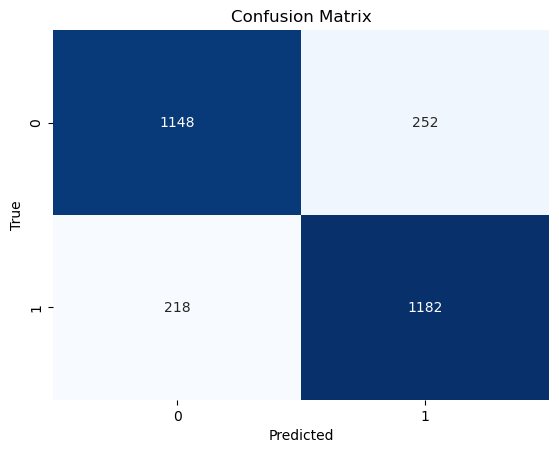

In [10]:
svm = SVC(kernel="rbf", probability=True, random_state=42)
svm.fit(X_lab, y_lab)
weak_labels_svm = svm.predict(X_unl)

metrics_svm = evaluate(y_unl, weak_labels_svm, plot_confusion_matrix=True)

### Comparison of all approaches

In [11]:
summary = pd.DataFrame({
    "LogisticRegression": metrics_lr,
    "KNN":                metrics_knn,
    "RandomForest":       metrics_rf,
    "SVM":                metrics_svm,
}).T

summary

,classification_report,accuracy,precision,recall,f1
LogisticRegression,"{'0': {'precision': 0.8341637010676156, 'recal...",0.835357,0.836559,0.833571,0.835063
KNN,"{'0': {'precision': 0.687910643889619, 'recall...",0.704286,0.723787,0.660714,0.690814
RandomForest,"{'0': {'precision': 0.7794015309672929, 'recal...",0.786786,0.794571,0.773571,0.783931
SVM,"{'0': {'precision': 0.8404099560761347, 'recal...",0.832143,0.824268,0.844286,0.834157


### Saving the best model

In [12]:
# Pick the best weak-labeler by F1
best_name = summary["f1"].idxmax()
best_clf  = {"LogisticRegression": lr,
             "KNN":                knn,
             "RandomForest":       rf,
             "SVM":                svm}[best_name]

# Ensure the results/weak_labeling directory exists
os.makedirs("../results/weak_labeling", exist_ok=True)

# Save to disk in the specified directory
save_path = f"../results/weak_labeling/best_weak_labeler_{best_name}.joblib"
joblib.dump(best_clf, save_path)
print(f"Saved best weak labeler model: {best_name}")

Saved best weak labeler model: LogisticRegression
